In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, mutual_info_classif

In [ ]:
df = pd.read_csv('processed_reviews_100k_cleaned.csv')
df.head()

,rating,title,text,timestamp,helpful_vote,verified_purchase,label,full_text,sentiment
0,1.0,malware,mcaffee IS malware,1562182632076,0,0,negative,malware mcaffee is malware,negative
1,5.0,Lots of Fun,I love playing tapped out because it is fun to...,1424120336000,0,1,positive,lots of fun i love playing tapped out because ...,positive
2,5.0,Light Up The Dark,I love this flashlight app! It really illumin...,1362399267000,0,1,positive,light up the dark i love this flashlight app i...,positive
3,4.0,Fun game,One of my favorite games,1561061428662,0,1,positive,fun game one of my favorite games,positive
4,4.0,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,1418257196000,0,1,positive,i am not that good at it but my kids are cute ...,positive


In [ ]:
print("shape ",df.shape)
print("checking if data is missing",df.isnull().sum())
print("data types of columns",df.dtypes)

shape  (7000, 9)
checking if data is missing rating               0
title                1
text                 0
timestamp            0
helpful_vote         0
verified_purchase    0
label                0
full_text            0
sentiment            0
dtype: int64
data types of columns rating               float64
title                 object
text                  object
timestamp              int64
helpful_vote           int64
verified_purchase      int64
label                 object
full_text             object
sentiment             object
dtype: object


In [ ]:
#Summary statistics for numeric columns
df.describe()

,rating,timestamp,helpful_vote,verified_purchase
count,7000.000000,7.000000e+03,7000.000000,7000.000000
mean,3.818714,1.501941e+12,4.374429,0.924714
std,1.462048,9.431288e+10,19.697272,0.263871
min,1.000000,9.657194e+11,0.000000,0.000000
25%,3.000000,1.439108e+12,0.000000,1.000000
50%,5.000000,1.514800e+12,0.000000,1.000000
75%,5.000000,1.572353e+12,3.000000,1.000000
max,5.000000,1.678895e+12,797.000000,1.000000


In [ ]:
# Check the value counts of relevant categorical columns (e.g., "rating", "helpfulness")
df['rating'].value_counts()

,count
rating,
5.0,3521
4.0,1163
1.0,966
3.0,808
2.0,542


In [ ]:
rating_counts = df["rating"].value_counts().sort_index()
rating_percentages = (rating_counts / rating_counts.sum()) * 100

# Display nicely
rating_distribution = pd.DataFrame({
    "count": rating_counts,
    "percentage": rating_percentages.round(2)
})

print(rating_distribution)

        count  percentage
rating                   
1.0       966       13.80
2.0       542        7.74
3.0       808       11.54
4.0      1163       16.61
5.0      3521       50.30


<Axes: title={'center': 'Distribution of Ratings'}, xlabel='rating'>

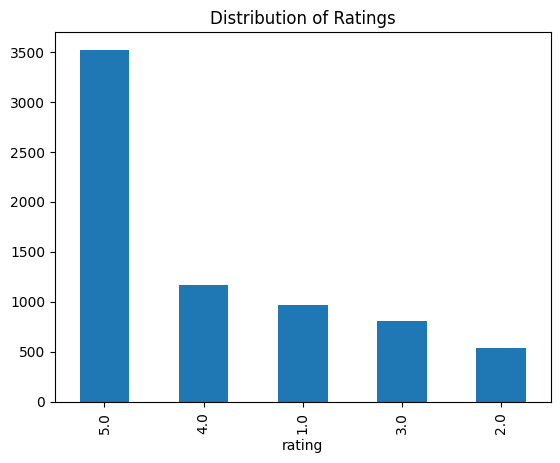

In [ ]:
# If the dataset has a rating column or sentiment labels, explore their distribution
df['rating'].value_counts().plot(kind='bar', title='Distribution of Ratings')

In [ ]:
sentiment_counts = df["sentiment"].value_counts()
sentiment_percentages = (sentiment_counts / len(df)) * 100
sentiment_summary = pd.DataFrame({
    "count": sentiment_counts,
    "percentage": sentiment_percentages.round(2)
})
print(sentiment_summary)

           count  percentage
sentiment                   
positive    4445       63.50
negative    1591       22.73
neutral      964       13.77


In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
#stemmer = PorterStemmer()

def preprocess(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize and remove stop words
    tokens = [word for word in text.split() if word not in stop_words]
    # Stemming
    #stemmed = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

# Apply to full_text (title+text)
df['clean_full_text'] = df['full_text'].apply(preprocess)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df[:50]

,rating,title,text,timestamp,helpful_vote,verified_purchase,label,full_text,sentiment,clean_full_text
0,1.0,malware,mcaffee IS malware,1562182632076,0,0,negative,malware mcaffee is malware,negative,malware mcaffee malware
1,5.0,Lots of Fun,I love playing tapped out because it is fun to...,1424120336000,0,1,positive,lots of fun i love playing tapped out because ...,positive,lots fun love playing tapped fun watch town gr...
2,5.0,Light Up The Dark,I love this flashlight app! It really illumin...,1362399267000,0,1,positive,light up the dark i love this flashlight app i...,positive,light dark love flashlight app really illumina...
3,4.0,Fun game,One of my favorite games,1561061428662,0,1,positive,fun game one of my favorite games,positive,fun game one favorite games
4,4.0,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,1418257196000,0,1,positive,i am not that good at it but my kids are cute ...,positive,good kids cute game good kids love nik wallenda
5,4.0,good game,"Made me think , variety of the puzzles kept it...",1374994387000,0,1,positive,good game made me think variety of the puzzles...,positive,good game made think variety puzzles kept fun ...
6,5.0,My favorite showVoice my favorite show,See the voice anytime my My favorite show,1520456160247,0,1,positive,my favorite showvoice my favorite show see the...,positive,favorite showvoice favorite show see voice any...
7,5.0,Great Antivirus product,Not sure what else can be said about Norton pr...,1384358113000,0,0,positive,great antivirus product not sure what else can...,positive,great antivirus product sure else said norton ...
8,1.0,Fraught with too many problems,Save your money and purchase a good (i.e. Nort...,1366378695000,0,0,negative,fraught with too many problems save your money...,negative,fraught many problems save money purchase good...
9,4.0,Norton Internet Security,I always use Norton as my PC security applicat...,1365671303000,0,0,positive,norton internet security i always use norton a...,positive,norton internet security always use norton pc ...


In [ ]:
X = df['clean_full_text']
y = df['sentiment']

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
# Split your data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#f1_scorer = make_scorer(f1_score, average='weighted')


# Pipeline avec Mutual Information
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mi', SelectKBest(score_func=mutual_info_classif)),  # <-- Remplacement ici
    ('clf', LinearSVC(class_weight='balanced'))
])

# Hyperparamètres à ajuster
param_grid = {
    'tfidf__max_features': [4000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'mi__k': [2000, 3000],
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__max_iter': [1000, 3000]
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Grid search
#grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring=f1_scorer, n_jobs=-1)
grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

#Predictions on test set
y_pred = grid.predict(X_test)

# Print best parameters (based on F1)
print("Best max_features (TF-IDF):", grid.best_params_['tfidf__max_features'])
print("Best ngram_range (TF-IDF):", grid.best_params_['tfidf__ngram_range'])
print("Best k (SelectKBest):", grid.best_params_['mi__k'])
print("Best C (LinearSVC):", grid.best_params_['clf__C'])
print("Best parameters (accuracy):", grid.best_score_)

# Show both F1 and Accuracy on the test set
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))  #if classes are balanced
print("Test F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted')) #if classes are imbalanced
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))  # Shows precision, recall, F1 per class

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

